# Gaussian Process

## Introduction

[Gaussian process](https://en.wikipedia.org/wiki/Gaussian_process) has been used in supervised, unsupervised, and even reinforcement learning problems. It has a beautiful mathematical theory (for an overview of the subject, see [1]). In particular, its distribution can be considered as a distribution over functions. Many machine learning models give specific predictions, not how uncertainty the predictions are. Gaussian process particularly helps us solve such problems. In this tutorial, we will implement a Gaussian process regression model using Pyro:
$$f \sim \mathcal{GP}\left(0, \mathbf{K}_f(x, x')\right)$$
and
$$y = f + \epsilon,\quad \epsilon \sim \mathcal{N}\left(0, \beta^{-1}\mathbf{I}\right).$$

## Prepare

First, we need import necessary modules.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

import pyro
import pyro.distributions as dist
from pyro.infer import SVI
from pyro.optim import Adam
from pyro.params import param_with_module_name
from pyro.util import ng_ones, ng_zeros

We will use [radial basis function kernel](https://en.wikipedia.org/wiki/Radial_basis_function_kernel) (RBF kernel) as the kernel of Gaussian process:
$$ \mathbf{K}(x,x') = \sigma^2 \exp\left(-\frac{\|x-x'\|^2}{2l^2}\right),$$
where $\sigma^2$ is variance and $l$ is lengthscale of the RBF kernel. The implementation is a straightforward PyTorch `nn.Module`.

In [2]:
class RBFKernel(nn.Module):
    def __init__(self, variance=torch.ones(1), lengthscale=torch.ones(1)):
        super(RBFKernel, self).__init__()
        self.variance = nn.Parameter(variance)
        self.lengthscale = nn.Parameter(lengthscale)
    
    def forward(self, x, z=None):
        if z is None:
            z = x
        lengthscale = self.lengthscale
        x = x / lengthscale
        z = z / lengthscale
        xz = x.ger(z)
        xx = x.unsqueeze(1) ** 2
        zz = z.unsqueeze(0) ** 2
        k = self.variance * torch.exp(-0.5 * (xx - 2*xz + zz))
        return k
    
    def K(self, X, Z=None):
        return self(X, Z)

Currently, there is no implementation of multivariate normal distribution in Pyro. The covariance matrices of normal distribution in Gaussian Process's models are positive semi-definite. Hence, we can use a triangular version `MultivariateNormalTriL` (adapted from [tensorflow implementation](https://www.tensorflow.org/api_docs/python/tf/contrib/distributions/MultivariateNormalTriL)). It is a subclass of Pyro's [Distribution](http://docs.pyro.ai/primitive_dist.html#pyro.distributions.distribution.Distribution), which should have four methods `batch_shape`, `event_shape`, `sample`, and `batch_log_pdf`. We get samples from this distribution according to
$$ y = \mu + \mathbf{L}z,\quad z \sim \mathcal{N}\left(0,\mathbf{I}\right).$$

Note that $L$ is the lower triangular decomposition of the covariance matrix $K$.

In [3]:
class MultivariateNormalTriL(dist.Distribution):
    reparameterized = True
    
    def __init__(self, loc, scale):
        self.loc = loc  # play the role of mu
        self.scale = scale  # play the role of L
        super(MultivariateNormalTriL, self).__init__()

    def batch_shape(self, x=None):
        event_dim = 1
        loc = self.loc
        if x is not None:
            loc = self.loc.expand_as(x)
        return loc.size()[:-event_dim]

    def event_shape(self):
        event_dim = 1
        return self.loc.size()[-event_dim:]

    def sample(self):
        eps = Variable(torch.randn(self.loc.size()))
        z = self.loc + self.scale.matmul(eps)
        return z if self.reparameterized else z.detach()

    def batch_log_pdf(self, x):
        log_Z = (0.5 * self.loc.size(0) * Variable(torch.Tensor([2*np.pi])).log()
                 + self.scale.diag().log().sum())  # Z is the normalization constant
        y = self.scale.inverse().matmul(x - self.loc)
        return -0.5 * y.pow(2).sum() - log_Z

It is better to make visualizations for Gaussian process' implementation. So we create a convenient function to plot.

In [4]:
def plot(model=None, n_sample=0):
    plt.figure(figsize=(12, 6))
    plt.plot(X.data.numpy(), y.data.numpy(), 'kx')  # plot data
    if model is not None:
        Z = Variable(torch.linspace(-0.5, 5.5, 100), volatile=True)  # new input
        mean, cov = model(Z)  # mean and covariance matrix of output's Gaussian distribution
        sd = cov.diag().sqrt()  # standard derivation at each input
        plt.plot(Z.data.numpy(), mean.data.numpy(), 'r', lw=2)  # plot the mean
        plt.fill_between(Z.data.numpy(),
                         mean.data.numpy() - 2*sd.data.numpy(),
                         mean.data.numpy() + 2*sd.data.numpy(),
                         color='C0', alpha=0.3)  # fill the interval (mean-2.sd, mean+2.sd)
    if n_sample > 0:  # plot the samples
        samples = np.random.multivariate_normal(mean.data.numpy(), cov.data.numpy(),
                                                size=n_sample, check_valid='ignore')
        plt.plot(Z.data.numpy(), samples.T, 'C0', lw=2, alpha=0.4)
    plt.xlim(-0.5, 5.5)
    plt.ylim(-3, 3)

## Data

The data consists of $20$ points sampled from
$$ y = 0.5\sin(3x) + \epsilon, \quad \epsilon \sim \mathcal{N}(0, 0.5).$$

In [5]:
# source: http://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_noisy.html
N = 20
X = dist.Uniform(ng_zeros(N), ng_ones(N)*5).sample()
y = 0.5 * torch.sin(3*X) + dist.Normal(ng_zeros(N), ng_ones(N)*0.5).sample()

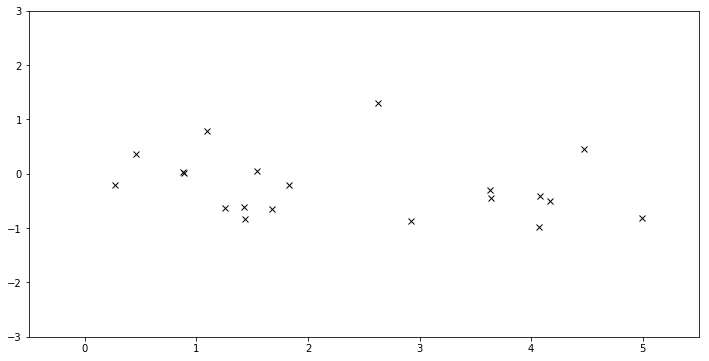

In [6]:
plot()

## Model

In [7]:
class GPRegressor(nn.Module):
    def __init__(self, X, y, kernel, priors={}, noise=0.01):
        super(GPRegressor, self).__init__()
        self.X = X
        self.y = y
        self.N = self.X.size(0)
        self.kernel = kernel
        self.priors = priors
        self.noise = ng_ones(1) * noise
        
    def model(self):
        kernel_fn = pyro.random_module("kernel", self.kernel, self.priors)
        kernel = kernel_fn()
        K = kernel.K(self.X) + self.noise.repeat(N).diag()
        L = K.potrf(upper=False)
        y = pyro.sample("f", MultivariateNormalTriL(ng_zeros(self.N), L), obs=self.y)
        
    def guide(self):
        guide_priors = {}
        for p in self.priors:
            p_MAP_name = param_with_module_name("kernel", p) + "_MAP"
            p_MAP = pyro.param(p_MAP_name, Variable(self.priors[p].analytic_mean().detach(),
                                                    requires_grad=True))
            guide_priors[p] = dist.Delta(p_MAP)
        kernel_fn = pyro.random_module("kernel", self.kernel, guide_priors)
        kernel = kernel_fn()
        return kernel
        
    def fit(self, lr=0.001, n_iter=1000):
        pyro.clear_param_store()
        optim = Adam({"lr": lr})
        svi = SVI(self.model, self.guide, optim, loss="ELBO", trace_graph=True)
        losses = []
        for i in range(n_iter):
            losses.append(svi.step())
        return losses
    
    def forward(self, Z):
        kernel = self.guide()
        K = kernel.K(self.X) + self.noise.repeat(self.N).diag()
        K_xz = kernel(self.X, Z)
        K_zx = K_xz.t()
        K_zz = kernel.K(Z)
        loc = K_zx.matmul(self.y.gesv(K)[0]).squeeze(1)
        scale = K_zz - K_zx.matmul(K_xz.gesv(K)[0])
        return loc, scale

### Define and plot model with initial parameters

In [8]:
kernel = RBFKernel()
model = GPRegressor(X, y, kernel)

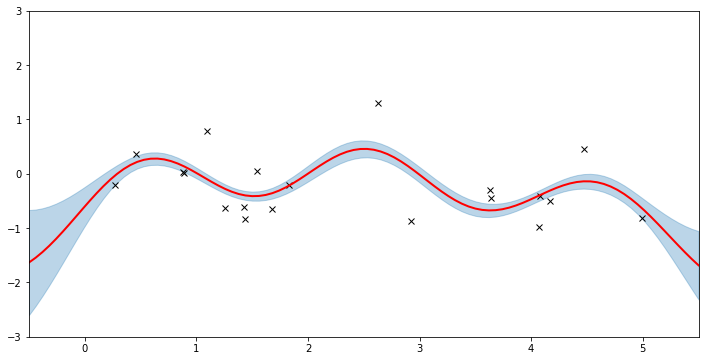

In [9]:
plot(model)

## Inference

In [10]:
losses = model.fit()

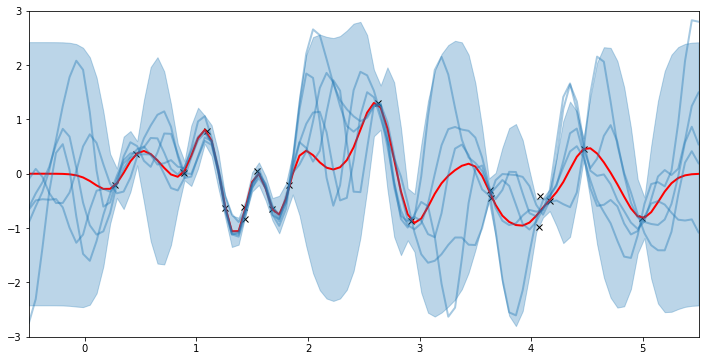

In [11]:
plot(model, n_sample=5)

#### Observe the loss

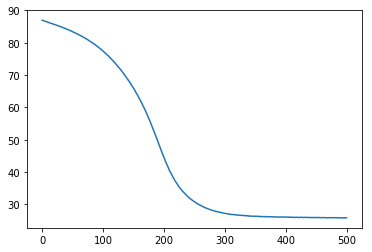

In [12]:
plt.plot(losses[-500:])

#### Observe the parameters

In [13]:
pyro.get_param_store().named_parameters()

dict_items([('kernel$$$lengthscale', Parameter containing:
 0.1491
[torch.FloatTensor of size 1]
), ('kernel$$$variance', Parameter containing:
 1.4649
[torch.FloatTensor of size 1]
)])

The larger lengthscale, we get the smoother samples. (explain) Variance control the derivation from the mean. (besides the fixed noise `0.01`)

Note that these parameters should be positive. To force such constraint, we need to use some kind of transform (e.g. `exp` or `softplus`). (more on this)

### Fit the model using MAP

We need to define the priors for parameters. Beside it is more reliable approach, it will also help dealing with the constraints of parameters.

In [14]:
# TODO

## Some remarks

+ In Gaussian Process, we usually have to solve the equation $Kx = y$, where $K$ is a positive covariance matrix. An efficiency and numerically-stable method to obtain the solution is to use [Cholesky decomposition](https://en.wikipedia.org/wiki/Cholesky_decomposition). First, we decompose $K = LL^T$, where $L$ is a lower triangular matrix. Then, we solve in turn $Lz = y$ and $L^Tx = z$. Some (fast) LAPACK operator in Pytorch (version 3.0) to solve linear equations with triangular matrix such as `torch.potrs` and `torch.trtrs` are [not differentiable](https://github.com/pytorch/pytorch/issues/440) (and also [not stable](https://github.com/pytorch/pytorch/issues/4296)). So, in the above implementation, we solve directly the system $Kx = y$ using `torch.gesv`.
+ The Cholesky decomposition `torch.potrf` usually throws the `RuntimeError`: "Lapack Error in potrf : the leading minor of order {} is not positive definite". The error tells itself: while decomposing, some eigenvalues of covariance matrix are approximately $0$ (and turn out to be negative). To deal with such error, instead of sampling $f$ from the decomposed lower triangle $L$ of $K(X, X)$ and sampling $y$ from $f$ with `noise`, we have to add `noise` to $K$ before decomposing matrix. Due to the `noise` component, all eigenvalues will be positive. Another way to deal with this error is to introduce the notion `jitter`. We will add a small positive term (named `jitter`) into the diagonal part of $K$ before decomposing the covariance matrix.
+ The above implementation of Gaussian process regression is quite simple, but it demonstates how flexible Pyro is. Without much modification, we can extend it to multidimensional cases (for both $X$ and $y$). Beside Kernels, as in [GPy](http://sheffieldml.github.io/GPy/), there are other components such as Likelihoods and Mean_functions. For example, Bernoulli likelihood is used in classification problems, Poisson likelihood is used in Poisson regression problems. All of them can be made modular (a.k.a. a subclass of `nn.Module`) like Kernels. 
+ Due to the flexibility of Pyro, we believe that it is just a matter of time until we have an established Gaussian process library in Pyro. The next release of PyTorch (version 0.4) will introduce a mature `torch.distributions` library, which will make probabilistic programming in Pyro much easier. In that version, changes such as "supporting scalar tensors" or "merging Tensor and Variable class" will also simplify the implementation of Gaussian Process a lot. Stay tuned!

## Reference

[1] `Deep Gaussian processes and variational propagation of uncertainty`,<br />&nbsp;&nbsp;&nbsp;&nbsp;
Andreas Damianou